# Bridging Diffusion Geometry to Curvature

Kincaid MacDonald [](https://orcid.org/0009-0006-4686-7488) (Yale)  
Dhananjay Bhaskar [](https://orcid.org/0000-0002-7859-8394) (MILA)  
Yanlei Zhang [](https://orcid.org/0000-0002-7859-8394) (MILA)  
Ian Adelstein [](https://orcid.org/0000-0002-7859-8394) (Yale Department of Math)  
Smita Krishnaswamy [](https://orcid.org/0000-0002-7859-8394) (Yale Department of Applied Math, Yale School of Medicine)  
August 13, 2024

Modeling data geometry has proven a rich source of interpretable features: quantifying ‘the shape’ of molecules, cellular trajectories, and code enhances downstream classification performance. Yet, creating these features requires a theoretical ‘Rosetta Stone’ to bridge geometric theory into the noisy, discrete world of real data. Various bridging paradigms have been proposed, most prominently *diffusion geometry* – and have given rise to manifold distance estimators, and manifold embedding techniques.However, the estimation of curvature remains relatively unexplored. Curvature, being the most local geometric measure, is among the most challenging concepts to bridge into the discrete realm; for this reason, it is also a sterling test a given paradigm’s ability to translate geometric theory into the sampled data.Here, we introduce *Diffusion Curvature*, a new definition of scalar curvature on point clouds which inherits diffusion geometry’s robustness to noise and sampling. In our benchmarks, diffusion curvature proves itself the *only* method capable of robustly differentiating positive and negative curvature in high dimensions, while its absence of parameters requiring user tuning makes it significantly more user-friendly than other methods.We describe theoretical connections between diffusion curvature and the Ollivier-Ricci curvature, and introduce a general paradigm for comparing diffusions across graphs.We apply diffusion curvature to neural loss landscapes, single-cell RNA data \[bit about what we find\] motivating the practical utility of our method.

------------------------------------------------------------------------

# 1. Introduction

The *Manifold Assumption* is among machine learning’s most prolific muses. Given only the knowledge that the local Euclidean distances between raw datapoints are meaningful, the Assumption grants a fount of theoretical intuition and methodological inspiration. It lies behind low-dimensional embedding and visualization techniques like PHATE, manifold distance estimators like HeatGeo, and the entire field of Topological Data Analysis ([Moon et al. 2019](#ref-moon2019VisualizingStructureTransitions); [Huguet et al. 2023](#ref-huguet2023HeatDiffusionPerspective)). It also invites one to use that theoretical inspiration to design new practical methods. Doing so, however, requires facing a sort of troll: one must bridge the idealized, analytic spaces of theory with the noisy, discrete world of real data. This is easier in some parts of theory than others. In particular, doing so is harder the more *locally* one tries to apply the Assumption. Global topological features are easier; manifold distances, harder; and manifold *curvatures*, perhaps the hardest of all.

But while distances or topological descriptors are widely used and have ready utility, one might be excused for asking “why care about curvatures?” A response, becoming more coherent with a raft of new graph and point-cloud curvature methods, is for its utility as a hyper-local descriptor of manifold geometry. There are many techniques, from Topological Data Analysis, to manifold distances estimators or graph or manifold embedding techniques that give global features. Curvature answers the opposing question: “*around this point, in this neighborhood, what’s happening to the local geometry*?” Such answers are directly interpretable in domains like single-cell biology, where curvature can indicate the extent of cell differentiation. They have also been shown to exceed and enhance the local discriminative powers of Graph Neural Networks (cite Bastian, COMPASS). (ADD other areas of application; reference Hickok & Sritharan). loss landscapes, eg

But notions of graph and point-cloud curvature are also particularly poignant for their theoretical implications. On one level, they are attempting to square an impossible circle. While global, topological features have a theoretical tolerance for discrete data, Riemannian geometry is built upon measures of *infinitesimal* locality – and curvature is the most local of Riemannian measurements. This is precisely where discrete data is the least reliable. Globally, point clouds can be recognized as manifolds, but zoom in to the locale of individual points, and the inevitable presence of noise and varying densities imbues the discrete manifold with a Heisenberg-like uncertainty: the smaller you go, the less you know of the local structure.

Hence the need for that ‘bridge’ – a Rosetta Stone, if you will – between the continuous, analytically-specified spaces of theory and the messy realities of actual data. The several existing discrete curvature methods chiefly use one of two classes of bridge: optimal transport, as in the field’s bulwark, Ollivier-Ricci curvature, and tangent-plane approximation, as used by methods like Sritharan and Adal-PCA (REFINE). This choice may seem inconsequential – it’s only curvature, after all – but precisely because curvature is so local, the ability of such a bridge to estimate curvature qualifies it for a much broader role: as a means to bring *general* geometric ideas into the discrete realm.

How effective are these bridges? To explore this, we develop a comprehensive benchmarking suite, and present the first quantitative comparison of discrete curvature methods – probing their tolerance to noise, high dimensions, and parameter perturbations. The landscape is, unfortunately, rather dismal. Most existing methods reliably fail to distinguish between negative and positive curvatures in high dimensions, degrade under small quantities of noise, and are highly dependent on the user tuning parameters which the user – not having access to the ground-truth curvatures – has no ability to tune. Graph curvature methods like Ollivier-Ricci and Forman-Ricci are difficult to translate to higher-density point cloud data, and point cloud methods like Sritharan, Hickok, and Adal-PCA depend on higher-order geometric concepts (like volumes and distances) whose estimation depends on curvature. This is both discouraging to those practitioners and academics thinking of incorporate curvature estimation in their research, and suggestive of a larger cavity in geometric featurization. None of these existing bridges pass the curvature test.

Perhaps the most well-traveled bridge in other areas of geometric estimation is data diffusion, or as often styled, “Diffusion Geometry”. Beginning in 2006 with Coifman & Lafon’s “Diffusion maps” ([Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)), this bridge operates through repeated application of a *diffusion operator* which can be thought of either as simulating heat diffusion, or performing a weighted random walk across data points. When iterated, this diffusion process performs a sort of ‘integration’ of local structure into a set of semi-local features which enable one to escape the confounding factors noise and sparsity. This idea underlies distance estimators like Diffusion Distances and HeatGeo Huguet et al. ([2023](#ref-huguet2023HeatDiffusionPerspective)), dimensionality-reduction methods like PHATE and GAGA ([Moon et al. 2019](#ref-moon2019VisualizingStructureTransitions)), and even a deep-learning based inference of the local Riemannian metric ([Fasina et al. 2023](#ref-fasina2023NeuralFIMLearning)). More generally, the diffusion-based *graph scattering transform* has inspired new graph neural network architectures with state-of-the-art performance on baselines requiring fine-grained local discrimination. (CHECK. IS THIS TRUE?)

Can this bridge of diffusion geometry pass the ‘curvature test’? Moreover, can it produce a curvature method robust enough to noise, dimension, and parameterization to be practically useful on point cloud data? In Bhaskar et al. ([2022](#ref-bhaskar2022DiffusionCurvatureEstimating)), we gave a preliminary positive answer with *diffusion laziness curvature*, an unsigned curvature derived from the diffusion operator. This strongly suggested that the powered diffusion operator contains curvature information, but was lacking both in theoretical pedigree and experimental validation on anything beyond 2-dimensional manifolds. We now present the maturation of this work.

*Diffusion Curvature* is a signed curvature based on diffusion geometry. It is resilient to noise, requires no user-tuned parameters, and robustly distinguishes between signs in high dimensions and under noise. We prove theoretical connections between diffusion curvature and the field’s bulwark, *Ollivier-Ricci Curvature*, which position diffusion curvature as a point-wise adaptation of Ollivier-Ricci - and further connect diffusion geometry to the optimal transport literature. More broadly, the success of diffusion-based techniques in determining curvature strongly motivates diffusion geometry as the missing Rosetta Stone between geometric theory and data science practice.

# 2. Background

## 2.1 Curvature in the Continuous Setting

There are many definitions of curvature on Riemannian manifolds. In this work, we focus on discrete analogs to the *Ricci* curvature $\text{Ric}(x,y)$, which we’ll briefly motivate in the continuous setting.

Imagine two spheres of equal radius centered at $x$ and $y$ in a Riemannian manifold $\mathcal{M}$. Intuitively, the Ricci curvature between $x$ and $y$ measures the difference between the distance of these midpoints, and the average distance between corresponding points in each sphere. In an area of positive Ricci curvature, points in spheres are, on average, closer than their midpoints; in negative Ricci curvature, the points in the sphere are further, on average, than the midpoints. This is formally described by first defining the *sectional curvature* as the contraction of length incurred by parallel transport through a 2-plane of the manifold, then defining the Ricci curvature as an average of the sectional curvatures between two points. For the present work, we needn’t reproduce the full definitions, but we will recall some properties of manifolds with Ricci curvature bounded from below by some $k$.

First, recall the relation between curvature and volume. In spaces of high positive curvature, the volume of a ball is than a ball of the same radius in a flat space, and even smaller than a ball of the same radius in a hyperbolic space. This is formally expressed by the Bishop Gromov inequality ([“Bishop–Gromov Inequality” 2021](#ref-2021BishopGromovInequality)).

<span class="theorem-title">**Theorem 1 (Bishop-Gromov) **</span>Let $\mathcal{M}$ be a complete $d$-dimensional Riemannian manifold with $Ric(x,y) > (d - 1)k$ for all $x,y \in \mathcal{M}$ and $k \in \mathbb{R}$. Let $M_{K}^d$ be the complete $d$-dimensional simply connected space of constant sectional curvature $k$. Denote by $B(x,k)$ the ball of radius $k$ centered at $x$. Then for any $x \in \mathcal{M}$ and $x_{k} \in M_{K}^d$, the function

$$
\phi(r) = \frac{\operatorname{Vol}B(x,r)}{\operatorname{Vol}B(x_{k},r)}
$$ is non-increasing on $(0,\infty)$.

This phenomenon of diminishing volume in positive curvature is related to the convergence of geodesic rays. In the plane (or saddle), two geodesic rays extending from the same point in different directions will never intersect. But on the sphere, they *will* meet again – at the opposite pole. This convergence constrains the maximum diameter a space of positive curvature may have, as expressed in the Bonnet-Myers Theorem ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)):

<span class="theorem-title">**Theorem 2 (Bonnet-Myers) **</span>Let $X$ be an $d$-dimensional Riemannian manifold. Let $\inf \operatorname{Ric}(X)$ be the infimum of the Ricci curvature $\operatorname{Ric}(v, v)$ over all unit tangent vectors $v$. Let $S^d \subset \mathbb{R}^{d+1}$ be the unit sphere of the same dimension as $X$. Then, if $\inf \operatorname{Ric}(X) \geqslant \inf \operatorname{Ric}\left(S^d\right)$ then $\operatorname{diam} X \leqslant \operatorname{diam} S^d$.

We’ll encounter versions of Bishop-Gromov and Bonnet-Myers in our discrete setting. But first, let’s describe the construction and properties of our specific discrete setting.

## 2.2 The Discrete Setting

Within the ambient setting of points $x_{i} \in \mathbb{R}^D$, the Euclidean distances between the points in our point cloud are not very useful. To perform geometric analysis, we want the manifold’s *geodesic* distances between $x_{i}, x_{j} \in \mathcal{M}$,. However, manifolds are locally euclidean, so within a sufficiently small neighborhood of $x_{i} \in \mathcal{M}$ , the euclidean distances are accurate. This is the basis of graph construction: retain only the trustworthy local distances, discard the rest, and then “integrate” over the local neighborhoods to recover features of the global geometry.

A graph $G = (V, E)$ is a collection of $n$ vertices $v_{i} \in V$ connected by (possibly weighted) edges $e_{ij} \in E$ . It is efficiently represented by a single *adjacency* (or *affinity*) matrix $A \in \mathbb{R}^{n \times n}$, where $A_{ij}$ expresses the degree of connection between the vertices $v_{i}$ and $v_{j}$. In a binary adjacency matrix, $A_{ij}=1$ iff there is an edge between $v_{i}$ and $v_{j}$. In a weighted affinity matrix, $0<A_{ij}<1$ with a higher affinity indicating a closer connection between the nodes.

One can construct an affinity matrix from a point cloud with the following algorithm: 1. Compute the matrix $D$ of pairwise euclidean distances between points, so that $D_{ij}=\|x_{i}-x_{j}\|_{2}$. 2. Apply a kernel $\kappa$ to the distances to construct the affinity matrix, where $A_{ij} = \kappa(D_{ij})$. This is typically the gaussian kernel: $$
\kappa(y) = \frac{1}{\sqrt{ 2\pi }\sigma}\exp\left( -\frac{y}{\sigma^2} \right)
$$ There are a variety of heuristics for selecting an appropriate kernel bandwidth $\sigma$. In this paper, we use an adaptive kernel bandwidth, in which, when computing $k(D_{ij})$, $\sigma$ is set to the mean distance from the points $x_{i}$ and $x_{j}$ to their $k$-th nearest neighbor.

After building our graph affinity matrix $A$, we created a new representation of the point cloud $X$ – turning it from an $n \times D$ matrix of unwieldy ambient coordinates into an $n \times n$ matrix of pairwise connections between points. The challenge is now to reassemble this information of local connectivity to recover the features of $\mathcal{M}$. Graph diffusion does precisely this.

## 2.3 Graph Diffusion

By row-normalizing $A$, one obtains the graph diffusion matrix $P = D^{-1}A$, which is a commonly-used method of “integrating” the local connectivity of the graph $A$ into global geometric descriptors of $\mathcal{M}$. Coifman and Lafon ([Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)) proved a correspondence between iterated graph diffusion $P^t$ and the Neumann heat kernel on $\mathcal{M}$. Their technique, *Diffusion Maps*, uses the Euclidean distances between eigencoordinates of $P$ to approximate the geodesic distances on $\mathcal{M}$. The visualization technique $PHATE$ ([Moon et al. 2019](#ref-moon2019VisualizingStructureTransitions)) constructs a low-dimensional embedding of a point cloud $X$ such that a distance between the transition probabilities $P$ of $X$ is preserved in the embedding. (More on properties of phate, trajectory preservation.) *Diffusion Earth Mover’s Distance* ([A. Y. Tong et al. 2021](#ref-tong2021DiffusionEarthMovera)) efficiently approximates the transportation distance between distributions on a graph using multi-scale wavelet transform obtained by applying different scales of diffusion. *LEGSNet*‘s “learnable geometric scattering” computes tunable scales of diffusion with a graph neural network and achieves state of the art performance on biochemistry graph classification ([A. Tong et al. 2021](#ref-tong2021DatadrivenLearningGeometric)). These are but a few of the many manifold learning techniques based in diffusion.

Constructing the diffusion matrix from the affinity matrix $A$ is straightforward: you simply row-normalize $A$, with an optional step to normalizing by density.

Here is the algorithm presented in Coifman and Lafon ([Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)):

1.  (Optional) Compute an *anisotropic density normalization* on $A$, obtaining the anisotropic adjacency matrix $A_{\star}$.
2.  Construct the degree matrix $D$, whose diagonal entries are the rowsums of $A$, i.e. $D_{ii} = \sum_{j}A_{ij}$.. The other entries are zeros.
3.  Define $P = D^{-1} A$, the graph diffusion matrix.

-   [ ] Clean this up: get anisotropic equation, and clarify the role of the self affinity. When is it removed? When is laziness added?

$P$ has several nice properties. The rows $P[i]$ give the transition probabilities of a single step random walk starting at point $x_{i}$; each row $P[i]$ can be viewed as a probability distribution centered at $x_{i}$. This is preserved under powers of the matrix. The rows of $P^t$ still sum to 1, and $P^t[i]$ now gives the probability distribution of a $t$-step random walk starting at $x_{i}$.

Although $P$ is not symmetric, it is conjugate to a symmetric matrix, via $D^{0.5}PD^{-0.5} = D^{-0.5}AD^{-0.5}$, granting it a full basis of real-valued eigenvectors and eigenvalues. These eigenvectors are shared with the normalized graph Laplacian $L = I - D^{-0.5}AD^{-0.5}$. The eigenvalues of $P$ have magnitude less than or equal to 1. Powering the matrix $P^t$ thus corresponds to powering the eigenvalues $\lambda_{i}^t$ of $P$, via diagonalization $$
P^t = \Psi \Lambda^t \Psi^T
$$ This is similar to applying a low-pass filter to the graph. As $t$ increases, the smallest eigenvalues decay fastest under repeated powering, and their corresponding eigenvector vanishes from the eigenbasis – leaving only the largest $\lambda_{i}$, whose eigenvectors trace global geometric features.

This is a remarkable feature of the diffusion matrix: the ability to “denoise” itself by iterating the random walk over larger time scales. Intuitively, the paths through the data most robustly trafficked by random walkers are those supported by multiple high-probability connections from independent starting points.

## 2.4 Ollivier-Ricci Curvature

Developed by Yann Ollivier in 2007, *Coarse Ricci Curvature* (or sometimes, “Ollivier Ricci Curvature”) is a direct translation of Ricci curvature to discrete metric spaces like graphs ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)). Several classical properties of Ricci curvature can be extended to the graph setting using Coarse Ricci Curvature. Ollivier has, for instance, proven versions of concentration inequalities, Bonnet Myers (more). Coarse Ricci Curvature has, in this way, become something of a bridge between continuous and coarse geometry. The basis of this bridge is optimal transport, and specifically, the 1-Wasserstein distance.

In the Riemannian setting, Ricci curvature captures the phenomenon that, in positive curvature, “small spheres are closer (in transportation distance) than their centers are” ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)). On the sphere, for instance, imagine two circles centered on the north and south poles: every point in each circle is closer to the corresponding point in the opposite circle than are the circles’ centers. This effect diminishes as one moves the circles closer together, but never reaches equality. In negatively curved spaces, the discrepancy reverses, while in a flat space, the average distance between the points of the circles is the distance between the centers.

Coarse Ricci Curvature captures a similar phenomenon on graphs. Instead of spheres, it uses locally-centered probability distributions defined by random walks. And to measure the distance between these walks, it uses the 1-Wasserstein (or Earth Mover’s) distance. We’ll briefly define each.

The 1-Wasserstein distance is a measure of the distance between probability distributions. Given distributions $\mu_{x}$ and $\mu_{y}$ over some shared space $X$, the Wasserstein distance quantifies the smallest amount of “work” needed to transform one distribution into another, by transporting probability “mass” between pairs of points over the ground metric $d(x,y)$:

<span class="theorem-title">**Definition 1 (1-Wasserstein Distance) **</span>The 1-Wasserstein distance between distributions $\mu_{x}$ and $\mu_{y}$ is $$ W_{1}(\mu_{x},\mu_{y}) := \inf_{\xi \in \Pi(\mu_{x},\mu_{u})} \int \int d(x,y) \, d\xi(x,y) $$ where the “transportation plan” $\xi$ is drawn from the space $\Pi(\mu_{x},\mu_{y})$ of joint probability distributions over $X \times X$ which project onto $\mu_{x}$ and $\mu_{y}$. In the discrete setting, this translates naturally into an infimum over a summation. $$W_{1}(\mu_{x},\mu_{y}) := \inf_{\xi \in \Pi(\mu_{x},\mu_{y})} \sum_{x \in X} \sum_{y \in X} d(x,y) \xi(x,y)$$

What is the analog on a graph of a “small sphere” around a point? Ollivier replaces spheres with a family of measures $m_{x}(\cdot)$ defined for each point $x$, where

1.  Each $\mu_{x}(\cdot)$ depends measurably on $x$, i.e. the map $x \to \mu_{x}$ is measurable.
2.  Each $\mu_{x}(\cdot)$ has finite first moment, or *Jump*, i.e. for some $o \in X$ $\int d(o,y) \mu_{x}(y) \, dx < \infty$.

In graphs, Ollivier defines these $\mu_x$ as the probability distributions created by a single-step random walk from the point $x$.

With a transition probability $\alpha$, and equal probability of moving to each of $x$’s neighbors on the graph, $\mu_{x}(x) = (1-\alpha)$ and $m_{x}(y) = \alpha$ if $y \in N(x)$ or $0$ otherwise.

This is analogous to defining $m_{x} = P e_{x}$, if $P$ is the diffusion matrix created from a binary adjacency matrix. Note, however, that there is nothing limiting us to binary adjacency matrices, or even single steps of diffusion; the two conditions above are equally satisfied by weighted adjacency matrices and $t$-step diffusions, and in sparse or noisy graphs, this may be desirable.

<span class="theorem-title">**Definition 2 (Coarse Ricci Curvature) **</span>The *Coarse Ricci Curvature* between $x$ and $y$ is $$\kappa(x, y):=1-\frac{W_1\left(m_x, m_y\right)}{d(x, y)}$$

There are a number of provisos attached to this definition, which tries to approximate a continuous phenomenon within discrete constraints. These constraints, and the relationship between Ricci and Ollivier’s coarse Ricci curvature are illustrated Ollivier’s Example 2.6 ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)):

<span class="theorem-title">**Example 1 **</span>Let $(X,d)$ be a smooth Riemannian manifold of dimension $d$ and let $\text{vol}$ be the Riemannian volume measure. Let $\epsilon>0$ small enough and consider the ball of radius $\epsilon$ around each point $x$. Let $x,y \in X$ be two sufficiently close points. Let $v$ be the unit tangent vector at $x$ directed towards $y$. The coarse Ricci curvature along $v$ is then $$\kappa(x,y) = \frac{\epsilon^2 \text{Ric}(v,v)}{2(d+2)}+o(\epsilon^3 + \epsilon^2d(x,y))$$

Hence the coarse Ricci curvature applied to a manifold recovers the Ricci curvature, up to a scaling factor contingent on dimension, and plus an error term that grows with the radius of ball and distance between points.

Ollivier’s choice not to scale $\kappa(x,y)$ by dimension is interesting, and likely motivated by his application of coarse Ricci curvature to graph-like spaces for which dimension isn’t clearly defined, like social networks. Within our domain of point-cloud data, incorporating dimension may be desirable; without it, spaces of high dimension can be conflated with spaces of lower dimension but higher negative curvature.

A result on coarse Ricci curvature which will prove useful concerns the *contraction (or expansion) of measure* that occurs under diffusion in spaces of positive (or negative) curvature. This is Ollivier ([2009](#ref-ollivier2009RicciCurvatureMarkov))’s Proposition 20:

<span class="theorem-title">**Proposition 1 ($W_1$ Contraction of Measure) **</span>Let $(X,d,m)$ be a metric space with a random walk. Let $\kappa \in \mathbb{R}$. Then we have $\kappa(x,y) \geq \kappa$ for all $x,y \in X$ iff for any two probability distributions $\mu, \mu' \in \mathcal{P}(X)$ one has

$$
W_{1}(\mu \star m, \mu' \star m) \leq (1-k)W_{1}(\mu, \mu')
$$ Where $$
 \mu \star m := \int_{{x \in X}} d\mu(x)m_{x} \, dx
$$

# 3. Methods

We consider a measure space $(X,p)$ equipped with a random walk, e.g. a point cloud and a diffusion operator derived as above. In this section, we define a new notion of curvature deriving from this random walk.

The core intuition of Diffusion Curvature is that the *laziness* of random walks on a graph is a proxy for the curvature of the underlying manifold. Picture a “random walker” drunkenly traversing a sphere. If he manages, over the course of several steps, to wander to the opposite pole, he has many ways of getting back to where he started. By contrast, if he begins on the top of a (negatively-curved) saddle and wanders down one side, any path aside from exactly retracing his steps incurs a steep penalty in extra distance. On the sphere, the random walker is more likely to find his way home: his walks are “lazier”.

Our previous paper ([Bhaskar et al. 2022](#ref-bhaskar2022DiffusionCurvatureEstimating)) measured this laziness directly, as the return probability within a k-neighborhood of the starting point. This required tuning the parameter $k$, and neglected the information provided by probabilities outside of this neighborhood.

We refine our previous definition of diffusion laziness by replacing the neighborhood-sum with a distributional distance measure $D$ between a dirac $\delta_{x}$ and its $t$-step diffusion $p_{x}^X(t)$. This provides a more sensitive and parameter-free measure of how ‘spread out’ the diffusion is.

<span class="theorem-title">**Definition 3 (Diffusion Energy) **</span>Given some distributional distance $D$, the $D$-energy snapshot of a diffusion $p_{x}^X(t)$ at time $t$ is $$
l_{X}(x,t) := D\left(\delta_x, p_x^X(t)\right)
$$

By $p_{x}^X(t)$, we indicate the $t$-step diffusion of the dirac $\delta_{x}$ centered at $x \in X$, using the diffusion operator for the measure space $X$. We use the term ‘Diffusion Energy’ in reference to our previous work (CITE), which measured curvature via ‘Diffusion Laziness’. That laziness measurement increased with positive curvature; diffusion energy does the opposite, increasing with more negative curvature.

The distributional distance $D$ may be the Wasserstein-1 distance, as with Ollivier-Ricci curvature; it may be the Jensen-Shannon Distance, evoking the classical use of entropy to measure the diffusion of heat; or it may be some other domain-specific form chosen for a particular metric measure space.

This measure of diffusion energy provides a snapshot of curvature at single diffusion time. However, this curvature is unsigned, and sensitive to the choice of $t$. Moreover, as we’ll discuss, differences in graph construction cause the times associated with the diffusion operators from different spaces to change at different speeds. This makes it hard to compare the geometric information gleaned from the diffusion operator across manifolds in terms of time.

To remedy this, we perform a change of variable, from the diffusion time $t$ to a *Diffusion Trajectory Distance*. As $t$ ranges from 0 to $\infty$, the diffusions $p_{x}^X(t)$ can be viewed as a trajectory on the $n$-dimensional probability simplex, where $n$ is the number of points in $X$. Given some Riemannian metric ${} g_{p} {}$ on the probability simplex (e.g. the Fisher Information Metric), we define the Diffusion Trajectory Distance of scale $t$ as the arc length of the trajectory to $p_{x}^X(t)$.

<span class="theorem-title">**Definition 4 (Diffusion Trajectory Distance) **</span>$$
d_{DTD}(x, t)= \int_{\tau=0}^{t} g_p\left(\frac{d p_x^X(\tau)}{d \tau}, \frac{ d p_x^X(\tau) }{d \tau} \right)
$$

This function produces the diffusion trajectory distance corresponding to each $t$. We also consider the inverse, which translates from diffusion trajectory distances to $t$.

$$
t_{DTD}(x,d) = d_{DTD}^{-1}(x,t)
$$

While the speed of diffusion (and hence, scale of $t$) varies between datasets – e.g. the same value of $t$ may correspond to a small diffusion in one setting, and one nearing steady-state in another – the diffusion trajectory distance is directly comparable between datasets. The function $t_{DTD}$ thus allows to to compare diffusion energies between across measure spaces, giving rise to a signed curvature.

<span class="theorem-title">**Definition 5 (Diffusion Curvature) **</span>Given a finite collection of points $X \subseteq \mathcal{M}$, where $\mathcal{M}$ is a Riemannian manifold of intrinsic dimension $n$, the *Diffusion Curvature* of $x \in X$ is

$$
k_(x, d) = l_{E} (x,t_{DTD}(x,d)) - l_{X}(x, t_{DTD}(x,d))
$$ where ${} E \subseteq \mathbb{R}^n {}$ is a collection of uniformly sampled points from $\mathbb{R}^n$.

In practice, we don’t have an infinitesimal parameterization of $p_{x}^X$, so instead of computing the diffusion trajectory distances as a path integral, we approximate them as a piecewise sum of distributional distances: we compute $T$ scales of diffusion (e.g. 50), sum the distributional distances between each scale to estimate the path integral, and from this derive $t_{DTD}$ via a piecewise linear approximation of $d_{DTD}$. This algorithm is summarized by Box WAWA.

The usefulness of this definition rests upon two claims:

1.  That diffusion energy is indeed a measure of (unsigned) curvature
2.  That our integration along diffusion trajectories enables this energy to be compared across point clouds with different diffusion processes.

The next two sections will analyze this first claim. We first analyze diffusion energy within Ollivier’s framework of metric measure theory, and bound the diffusion energy from above by the Ollivier-Ricci curvature. We then provide a motivating example recovering a Bishop-Gromov type volume comparison from the diffusion curvature with an entropic distance.

Finally, we support the second claim with illustrations of point clouds which diffusion trajectories can uniquely compare. We also describe how common techniques of constructing graphs from point clouds can obscure geometric information, and propose a ‘curvature-agnostic kernel’ to facilitate more geometrically-faithful graph construction.

## 3.1 Diffusion Energy is bounded by Ollivier-Ricci curvature

Ollivier Ricci curvature measures the extent to which ‘spheres are closer than their centers’, using graph diffusions to create spheres, and optimal transport to measure distances. Diffusion energy uses both ingredients. But whereas Ollivier Ricci curvature takes the Wasserstein distance between spheres of the same size, Diffusion energy takes the distance between successive sizes of the same sphere.

This simplification makes Diffusion energy more localized and much computationally lighter. Here we demonstrate that it also retains the theoretical guarantees of Ollivier Ricci curvature, and might be though of as a natural node-wise adaptation of Ollivier Ricci curvature.

<span class="theorem-title">**Proposition 2 (Coarse Ricci Curvature Bounds Diffusion Energy) **</span>Let $(X,d,m)$ be a metric space equipped with a random walk, with coarse Ricci curvature bounded from below by some $k$ such that $\kappa(x,y) \geq k$ for all $x,y \in X$. The diffusion energy of a $t$ step diffusion in $X$ is bounded above by $$
W_{1}(\delta_{x}, m_{x}^t) \leq W_1\left(\delta_x,m_x\right)\frac{(1-(1-k)^t)}{k}
$$

In particular, if $k>0$ then $W_{1}(\delta_{x},m_{x}^t) \leq \frac{W_1\left(\delta_x,m_x\right)}{k}$, and if $k=0$, then $W_{1}(\delta_{x},m_{x}^t) \leq tW_1\left(\delta_x,m_x\right)$.

To prove this, first we bound $W_{1}(m_{x}^t,m_{x}^{t+1})$ using <a href="#prp-ollivier-contraction-of-measure" class="quarto-xref">Proposition 1</a>. The proposition states that a lower bound on curvature, such as we have, implies that $$
W_{1}(\mu \star m, \mu' \star m) \leq (1-k)W_{1}(\mu, \mu')
$$ where here $\mu,\mu'$ are two probability distributions and $m$ is a random walk. This provides an easy lemma:

<span class="theorem-title">**Lemma 1 (Inductive Contraction of Measure) **</span>Let $(X,d,m)$ be a metric space with a random walk. Suppose there is some $k \in \mathbb{R}$ such that the coarse Ricci curvature $\kappa(x,y) \geq k$ for all $x,y \in X$. Then: $$
W_1\left(m_x^t, m_x^{t+1}\right) \leq(1-k)^t W_1\left(\delta_x,m_x\right)
$$

<span class="proof-title">*Proof*. </span>We proceed by induction. For $t=0$, the above is true, as $W_{1}(m_{x}^0, m_{x}^{1}) =W_{1}(\delta_x, m_{x}^{1}) = W_1\left(\delta_x,m_x\right)$. Suppose it holds for $t-1$, e.g. $$
W_1\left(m_x^{t-1}, m_x^{t}\right) \leq(1-k)^{t-1} W_1\left(\delta_x,m_x\right)
$$

Consider $W_1\left(m_x^{t-1}\star m, m_x^{t}\star m\right)$, the application of another step of diffusion. By Ollivier’s Proposition 20, this distance is bounded above by $$
W_1\left(\mu_1 \star m, \mu_2 \star m\right) \leq(1-k) W_1\left(\mu_1, \mu_2\right)
$$ So $$
W_1\left(m_x^{t-1}\star m, m_x^{t}\star m\right) \leq  (1-k)W_1\left(m_x^{t-1}, m_x^{t}\right)
$$

which, since the statement holds for $t-1$, yields $$
W_1\left(m_x^t, m_x^{t+1}\right) \leq(1-k)^t W_1\left(\delta_x,m_x\right)
$$

We can now use this lemma to decompose our $t$-step diffusion into a sum of single-step diffusions, allowing an easy proof of the proposition.

<span class="proof-title">*Proof*. </span>By the triangle inequality, $$
W_{1}(\delta_{x},m_{x}^t) \leq W_1\left(\delta_x,m_x\right) + W_{1}(m_{x},m_{x}^2) + \dots + W_{1}(m_{x}^{t-1}, m_{x}^t)
$$

By <a href="#lem-inductive-contraction-of-measure" class="quarto-xref">Lemma 1</a>, $$
\leq W_1\left(\delta_x,m_x\right)\left(1+(1-k)+(1-k)^2+\ldots+(1-k)^{t-1}\right)
$$

This truncated series is equal to $\frac{1-(1-k)^t}{1-(1-k)} = \frac{(1-(1-k)^t)}{k}$. If $k>0$, then as $t \to \infty$, the infinite sum $\sum_{i=0}^t (1-k)^i$ converges to the geometric series $\frac{1}{1-(1-k)} = \frac{1}{k}$. Because the sum is monotonically increasing with $t$, the partial sum is upper bounded by the infinite sum. It follows that $$
W_{1}(\delta_{x},m_{x}^t) \leq \frac{W_1\left(\delta_x,m_x\right)}{k}
$$

If $k=0$, then obviously $\sum_{i}^t (1-k)^i = t$.

The above shows that the diffusion energy $l_{W_1}$ has an upper-bound given by the Ollivier Ricci curvature. We expect that the higher a manifold’s curvature, the lower $l_{W_{1}}$ should be. This is formalized by Proposition 1: the higher the Ollivier-Ricci curvature of a manifold, the smaller its diffusion energy. This result motivates the use of diffusion curvature as a point-wise adaptation of Ollivier-Ricci curvature.

## 3.2 A Motivating Example: Entropic Diffusion Curvature Recovers a Bishop-Gromov Volume Comparison

Among the most obvious manifestations of curvature is differences in volume: the higher the curvature, the smaller the volume of geodesic balls of the same radius. In the continuous setting, this is expressed by <a href="#thm-bishop-gromov" class="quarto-xref">Theorem 1</a>.

One route to discrete curvature is thus estimating volumes; this is the route taken by Hickok and Blumberg ([2023](#ref-hickok2023IntrinsicApproachScalarCurvature)). However, standard methods of estimating volumes in discrete, sampled spaces like point clouds or graphs rely on more complex geometric quantities, like density estimation or approximated geodesic distances, which are not only susceptible to noise, but often themselves dependent on the curvature![1] One wonders: can we use the tools of diffusion geometry to robustly estimate volume?

Indeed, this is one way to interpret diffusion energy: as an inverse volume measurement. Huguet et al. ([2023](#ref-huguet2023HeatDiffusionPerspective)) motivates this with a result from Saloff Costes et al. ([Saloff-Coste 2010](#ref-saloff-coste2010HeatKernelIts)). For manifold satisfying the Parabolic Harnock Inequality (e.g. all manifolds of positive curvature), heat diffusion $m_{x}^t$ on the manifold is bounded by

$$
\frac{c_1}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_2 t}\right) \leq m_{x}^t(y) \leq \frac{c_3}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_4 t}\right)
$$

In other words, heat diffusion on non-Euclidean manifolds behaves approximately like Euclidean heat diffusion scaled by the local volume.

Powering the diffusion matrix approximates heat diffusion \[cite Coifman\]. We can thus relate our measure of the ‘spread’ or ‘energy’ of this diffusion to the manifold’s volume.

The Shannon entropy of the diffusion $m_{x}$ over the bounded neighborhood of $X$ with non-zero diffusion mass, can be written $$
H\left(m_x^t\right)=-\int_{y_\epsilon x} m_x^t(y) \ln \left(m_x^t(y)\right)
$$ Here we use Shannon’s differential entropy.Though this formulation encounters pathologies on unbounded domains, it approximates the entropy a signal on a sampled region as the number of samples goes to infinity.

We’ll simplify the notation by combining the integral and distribution into an expected value over $m_{x}^t$ $$
=-\mathbb{E}_{m_x} \ln \left(m_x(y)\right) d y
$$ Recalling the above result, there are constants $c_{1}\dots c_{4}$ such that

$$
\frac{c_1}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_2 t}\right) \leq m_{x}^t(y) \leq \frac{c_3}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_4 t}\right)
$$ hence we can approximate $H(m_{x}^t)$ by

$$
=-\mathbb{E}_{m_{x}^t} \ln \left(\frac{1}{V(y, \sqrt{t})} \exp \left(\frac{-d(x, y)^2}{4 t}\right)\right)
$$ $$
=-\mathbb{E}_{m_x^t} \ln \left(\frac{1}{V(y, \sqrt{6})}\right)-\frac{d(x, y)^2}{4 t}
$$ $$
=\mathbb{E}_{m_x^t} \ln (V(y, \sqrt{t}))+\mathbb{E}_{m_{x}^t} \frac{d(x, y)^2}{4 t}
$$

By assumption, the volumes $V(y,\sqrt{ t })$ equal some constant $V_{m}(\sqrt{ t })$ over the support of $m_{x}^t$. Also note that the right hand term is precisely $\frac{1}{4t}W_{2}(\delta_{x}, m_{x}^t)$, so $$
H(m_{x}^t) \simeq \ln(V_{m}(\sqrt{ t })) + \frac{1}{4t}W_{2}(d_{x},m_{x}^t)
$$ The Diffusion Curvature is then $$
\frac{1}{t}(H(m_{E}^t) - H(m_{x}^t)) \simeq \frac{1}{t}\ln(V_{E}(\sqrt{ t })) - \frac{1}{t}\ln(V_{m}(\sqrt{ t })) + \frac{1}{4t^2}( W_{2}(d_{x},m_{E}^t) - W_{2}(d_{x},m_{x}^t))
$$

This presents us with two comparisons: one between the average volume within $N_{t}(x)$ both in Euclidean space and on the manifold, and one between the Wasserstein spread of diffusion in Euclidean space and on the manifold. Note that both exhibit the same inverse relationship to curvature. If the curvature of $m$ is greater than in euclidean space (e.g. positive), the volume of a ball is smaller – just as the spread of diffusion is diminished. In negative curvature, we have the opposite.

## 3.3 Diffusion Trajectory Aligment: Comparing Diffusion Across Point Clouds

### 3.3.1 Problem Setting & Motivation

For a single graph, the energy of diffusion is linked to graph volume and theoretically bounded by curvature. Within a given graph, the lower the curvature, the higher the diffusion energy. As shown above, we can draw analogy to Bishop-Gromov to convert this unsigned magnitude-of-curvature estimation to a signed curvature via a comparison between spaces.

A comparison like this is at the heart of many discrete curvatures. Ollivier-Ricci compares the transport distance between two distributions with the transport distance on a flat space. Hickok and Blumberg compare the approximate the volume of balls on a given point cloud with the Euclidean volume of balls with the same radius. In these definitions, the use of more complex geometric constructs (distances, volumes, densities) grants the Euclidean comparison an analytic form. Our definition makes a different trade-off: it doesn’t depend on the error-prone approximations of those higher-order phenomena, but it doesn’t benefit from their theoretical simplicity.

To put it bluntly, there’s no analytical form of, e.g. the diffusion energy in $\mathbb{R}^8$ at $t=25$ because there’s no single translation between $\mathbb{R}^8$ and one of the “discrete measure space with a random walk” our definition operates on. There are many different ways of uniformly sampling $N$ points from $\mathbb{R}^d$ – and there are many ways of turning those points into a graph. But different samplings, and different modes of graph construction result in different *speeds of diffusion* on the graph, rendering direct comparison of diffusion energies difficult.

For example, imagine constructing two $k$-nearest neighbor graphs with a different value of $k$ for each pointcloud. In the graph constructed with a larger $k$, diffusion will happen more quickly because everything is more tightly connected. The diffusion energy of a point on this graph, at any given $t$, will appear much higher than its sister graph – even if both were constructed from the same space! The vagaries of graph construction have obscured the underlying geometry of the manifold.

An immediate workaround is to try to bypass this obstruction by constructing graphs in *exactly* the same manner from both our target points and comparison points. One might use a $k$nn graph with identical $k$’s, or an adaptive kernel which sets the bandwidth locally based on the distance to each nearest neighbor. We experimented with this approach extensively, and came to the unexpected conclusion that the interplay between curvature and distance makes it extremely hard to create a kernel with the same relative bandwidth in spaces of differing curvatures. Specifically, the local Euclidean distance used by standard graph construction techniques like the k-neighbor adaptive kernel becomes less reliable the greater the magnitude of curvature. Thus, not only are comparisons between spaces compromised, but even the geometric information within a space is obscured by a gratuitously fluctuating kernel bandwidth. We explore this in more detail in the next section, and propose a simple change which lessens these symptoms.

However, the underlying ‘disease’ remains: although we assume our point clouds are sampled manifolds, there’s no one-to-one translation between these manifolds and the measure spaces with random walks diffusion geometry operates on. Different samplings and different means of graph construction all create different random walks. Trying to homogenize these random walks via careful graph construction relies on geometric information, like distances, that we don’t (yet) have – and tries to wage war against the notoriously fickle process of sampling. Far better than trying to homogenize these random walks on the level of *graph construction* would be a method that can reliably compare diffusions *across* graphs.

This problem, of reliably comparing diffusions across graphs, has wide applicability. … research needed here … Other techniques partially address this by considering *multiscale diffusions*. The *multiscale diffusion distance* takes a weighted average across powers of diffusion. Diffusion Earth Mover’s Distance extends this to an optimal transport measure based on the differences distributions diffused at multiple scales. The *Graph scattering transform* produces a rich set of features for comparing graphs derived from differences between powers of diffusion. And many graph neural networks are built upon flavors of message passing which resemble graph diffusion, while others have been modeled on graph scattering. All of these methods come with a caveat: if compared across graphs, discrepancies in graph construction will manifest as spurious differences in graph geometry.

### 3.3.2 Diffusion Trajectory Alignment

We consider a new approach to this problem, which replaces the diffusion time $t$ – so heavily dependent on the vagaries of graph construction – with a distance along the *diffusion trajectory*. To obtain this, we view scales of diffusion as points along a trajectory on the $N$-dimensional probability simplex, where $N$ is the number of nodes on the graph.[2] We define the Diffusion Trajectory Distance as <a href="#def-diffusion-trajctory-distance" class="quarto-xref">Definition 4</a>:

$$
d_{DTD}(x, t)= \int_{\tau=0}^{t} g_p\left(\frac{d p_x^X(\tau)}{d \tau}, \frac{ d p_x^X(\tau) }{d \tau} \right)
$$

This trajectory has the advantage of erasing any differences caused by the speed of diffusion. Instead, we can use the distance along that trajectory *Diffusion Trajectory Distance*) to align the scales of diffusion between two graphs. As illustrated in <a href="#fig-curvature-curves" class="quarto-xref">Figure 1</a>, by comparing the diffusion energies of several graphs across their diffusion trajectory distances. Making the same comparison across times is uninformative - and misleadingly suggests that the sphere is the most negatively curved. *Diffusion Trajectory Alignment*, however, reveals the correct relation between the surfaces.

``` python
graph_former = partial(get_curvature_agnostic_graph, k = 2, neighbor_scale = 3, alpha=0, self_loops=True)

Saddle, Sphere, Plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(Saddle, Plane, Sphere, num_ts=50, title = "Diffusion Energy over Multiple Scales of Diffusion")
```

    2024-07-16 18:06:34,634:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
    2024-07-16 18:06:38,534:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
    2024-07-16 18:06:40,016:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
    2024-07-16 18:06:44,008:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
    2024-07-16 18:06:45,773:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
    2024-07-16 18:06:49,520:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!

![Figure 1: Diffusion energies across multiple scales on a 4-dimensional saddle, plane, and sphere (all 3-manifolds). When comparing directly between times, there is no clear separation of curvatures. Aligning diffusions by diffusion trajectory distance reveals curvature.](attachment:index_files/figure-ipynb/fig-curvature-curves-output-2.png)

Applying diffusion trajectory alignment to our diffusion energies also has the happy effect of focusing our measurement on the most relevant scales of diffusion. When using diffusion times, one must be careful to select a time around the ‘elbow’ of the diffusion energies (<a href="#def-energy-of-diffusion" class="quarto-xref">Definition 3</a>). Smaller $T$’s yield more localized measurements of curvature. But make $t$ too small, and the diffusion might have barely differentiated itself from a dirac, drowning the curvature in sampling-induced noise. Yet make $t$ too large, and the diffusion will progress to the uninformative steady-state distribution. With the diffusion trajectory distance, all of the undesirably large $t$’s are compressed into a narrow range of distances – the diffusion trajectory limits to the steady state distribution, and the diffusion trajectory distances that correspond to it are all within some $\epsilon$ of the maximum diffusion trajectory distance. Finding a time around the elbow of the diffusion energies then corresponds to choosing a diffusion distance within $80-95$% of the maximum; and via the inverse diffusion trajectory distance, $t_{DTD}$, this can be translated to the appropriate scale of $t$ for each dataset.

In practice, we don’t have access to a metric $g_{p}$ on the probability simplex; this space is too high-dimensional, and we lack a continuous parameterization of graph diffusion. Instead, we approximate this integral by measuring the distances between subsequent diffusions (performed for every integer $1 \leq t \leq T(d)$). This approximates the diffusion trajectory distances for each scale of diffusion, giving us discrete examples of $d_{DTD}$. We then construct a piecewise linear approximation of $d_{DTD}$ to estimate the inverse, $t_{DTD}$.

### 3.3.3 The Curvature-Agnostic Kernel & Automatic Bandwidth Tuning

Diffusion trajectory alignment significantly reduces the interference caused by graph construction, but does not completely eliminate it. Due to our lack of access to a diffusion coordinate space metric, and the approximations used for the diffusion trajectory distance, we find the robustness of our algorithm is significantly improved by a few adjustments to standard graph construction techniques to make them more curvature agnostic.

To turn a point cloud into a graph, one places a kernel (e.g. a gaussian) at each point, and assigns edges to surrounding points with weights given by the kernel. The main parameter here is the bandwidth of each kernel: make it too high, and everything is connected; too low, and points are isolated. Moreover, the distances between a point and its neighbors may vary. Where the points are sparse, one wants a higher bandwidth. Where dense, a lower bandwidth.

A standard technique for accommodating the variable densities of point cloud data is a $k$-neighbor *adaptive kernel*. Here, the bandwidth at each point is set to the squared distance to the $k$-th nearest neighbor, averaged in some way between the two inputs. Here’s one standard adaptive kernel:

$$
\begin{aligned}
k(x, y) & =\frac{e^{-\frac{d(x, y)^2}{d(x, N_{k}(x))^2}}}{d(y, N_{k}(y))}
+\frac{e^{-\frac{d(x, y)^2}{d(y, N_{k}(x))^2}}}{d(x, N_{k}(y)}
\end{aligned}
$$

where $N_{k}(x)$ gives the $k$th nearest neighbor to $x$.

Note that that parameter $k$ plays roles in two kinds of adaptation. By setting the bandwidth to some Euclidean distance $d(x,N_{k}(x))$ between data points, it adapts the kernel to the *right scale* for the point cloud, concentrating its probability within a local neighborhood. It also controls the *size* of that local neighborhood; typically set between 5 and 15.

Unfortunately, this adaptive process hinges on the correspondence between the Euclidean distances $d(x,N_{k}(x))$, and the manifold distances – a correspondence that degrades *faster* the higher the magnitude of curvature! Consider a highly-curved paraboloid. The Euclidean distance from its center point to its nearest few neighbors is roughly the geodesic distance. But as the neighborhood widens, and the neighbors move higher up the paraboloid, the Euclidean distance now underestimates the true geodesic distance: it cuts across the manifold. This happens in spaces of high positive or high negative curvature.

As a result, the adaptive kernel constructed in highly curved spaces has a smaller bandwidth than in flat spaces, even using the same kernel parameters. If one directly compares the laziness of diffusion on two such graphs, it will appear lazier than on the flat manifold.

To remedy this, we make a simple adjustment to the standard adaptive kernel. The key is separating the parameter which controls neighborhood size from neighborhood scale. In the adaptive kernel, both are controlled by the parameter $k$; as discussed above, in spaces of high curvature, the same $k$ creates different scales. Instead, we always set $k = 1$ and use another parameter – $\nu$, the neighbor-size – to control the variance of the kernel.

$$
\begin{aligned}
k(x, y) & =\frac{e^{-\frac{d(x, y)^2}{d(x, N_{k}(x))^2\nu^2}}}{d(y, N_{k}(y))}
+\frac{e^{-\frac{d(x, y)^2}{d(y, N_{k}(x))^2\nu^2}}}{d(x, N_{k}(y)}
\end{aligned}
$$

$\nu$ behaves like the kernel bandwidth in the regular fixed Gaussian kernel. We call this the *Curvature-Agnostic Kernel*.

-   [ ] Figure comparing the adaptive to curvature agnostic kernels with diffusion trajectory normalization. Use a stacked image.

Figure WAWA illustrates the increased robustness diffusion trajectory alignment gains from using this curvature-agnostic kernel. The relative ordering of graphs is still achieved by the traditional adaptive kernel, but is significantly denoised by these tweaks.

The main parameter of the curvature-agnostic kernel is the “neighbor scale” $\nu$, which sets the kernel bandwidth to the specified multiple of the average distance to the $k$th-nearest neighbor. As a single parameter, this can be tuned easily. We use as a heuristic the desired median number of points with non-negligible single-step diffusion probability, and perform a binary search over values of $\nu$ until this number is within a desired tolerance.

We suspect the curvature-agnostic kernel may be generally useful in manifold learning. In any downstream analysis that leverages the graph geometry – be it distance estimation, \[CITE HUGUET\] or metric learning \[CITE US\] – this analysis is made easier by a kernel whose bandwidth does not gratuitously fluctuate in regions of high curvature.

-   [ ] Can we provide experimental results here? Does PHATE or HeatGeo perform better with this kernel?

# 4. The Curvature Colosseum: A Discrete Curvature Benchmarking Suite

The discrete curvature literature lacks a standard benchmark. Previous work has used a combination of evaluations on 2-dimensional toy manifolds (where correctness is visually obvious) and generally one or two bespoke higher-dimensional test cases, on which the target method is extensively tuned – and even then, often has ambiguous results. Comparisons between methods have been scarce.

Thus, Ollivier-Ricci curvature was introduced mostly on toy-examples. It has since been compared to Forman-Ricci (BASTIAN) ??? Hickok & Blumberg primarily tested their method on the 2-dimensional torus and sphere. They compared to WAWA. However, their point clouds weren’t uniformly sampled with respect to the manifold geometry - causing some density artifacts. CHECK! Sritharan et al. performed the most extensive testing we have seen, with studies of correlation against ground truth and robustness to parameters. Zhang et al. compared accuracy at a variety of noise scales to Hickok & Blumberg and to our previous unsigned diffusion laziness curvature, but only on 2-dimensional manifolds.

To overcome these shortcomings, we propose a discrete-curvature benchmarking suite we affectionately dub the ‘Curvature Colosseum.’ It permits standardized comparison between methods on three axes:

1.  *Resilience to Noise.* Pearson correlations with ground truth curvature on 2-Dimensional manifolds across noise scales.
2.  *Accuracy on High Dimensions.* Pearson correlations with ground truth curvature on 3-8 dimensional surfaces.
3.  *Sign Prediction*. Ability to distinguish spaces of positive, negative, and zero curvature in dimensions 3-8.

Each of the manifolds used above is rejection sampled (CITE SOMEONE) to ensure uniform density with respect to manifold volume. When benchmarking curvature methods from the literature, we use their suggested parameters when available.

We provide full implementation details in the appendix. Our code is available at GITHUB LINK, along with a public dashboard of the results at ANOTHER LINK.

The remaining parts of this section detail the results of Diffusion Curvature and its competition on each axis of the Colosseum.

## 4.1 Performance in Low Dimensions under Noise

``` python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Hyperboloid', 'Ellipsoid']
labels = diffusion_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='coolwarm')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='coolwarm')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Diffusion Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Diffusion Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()
```

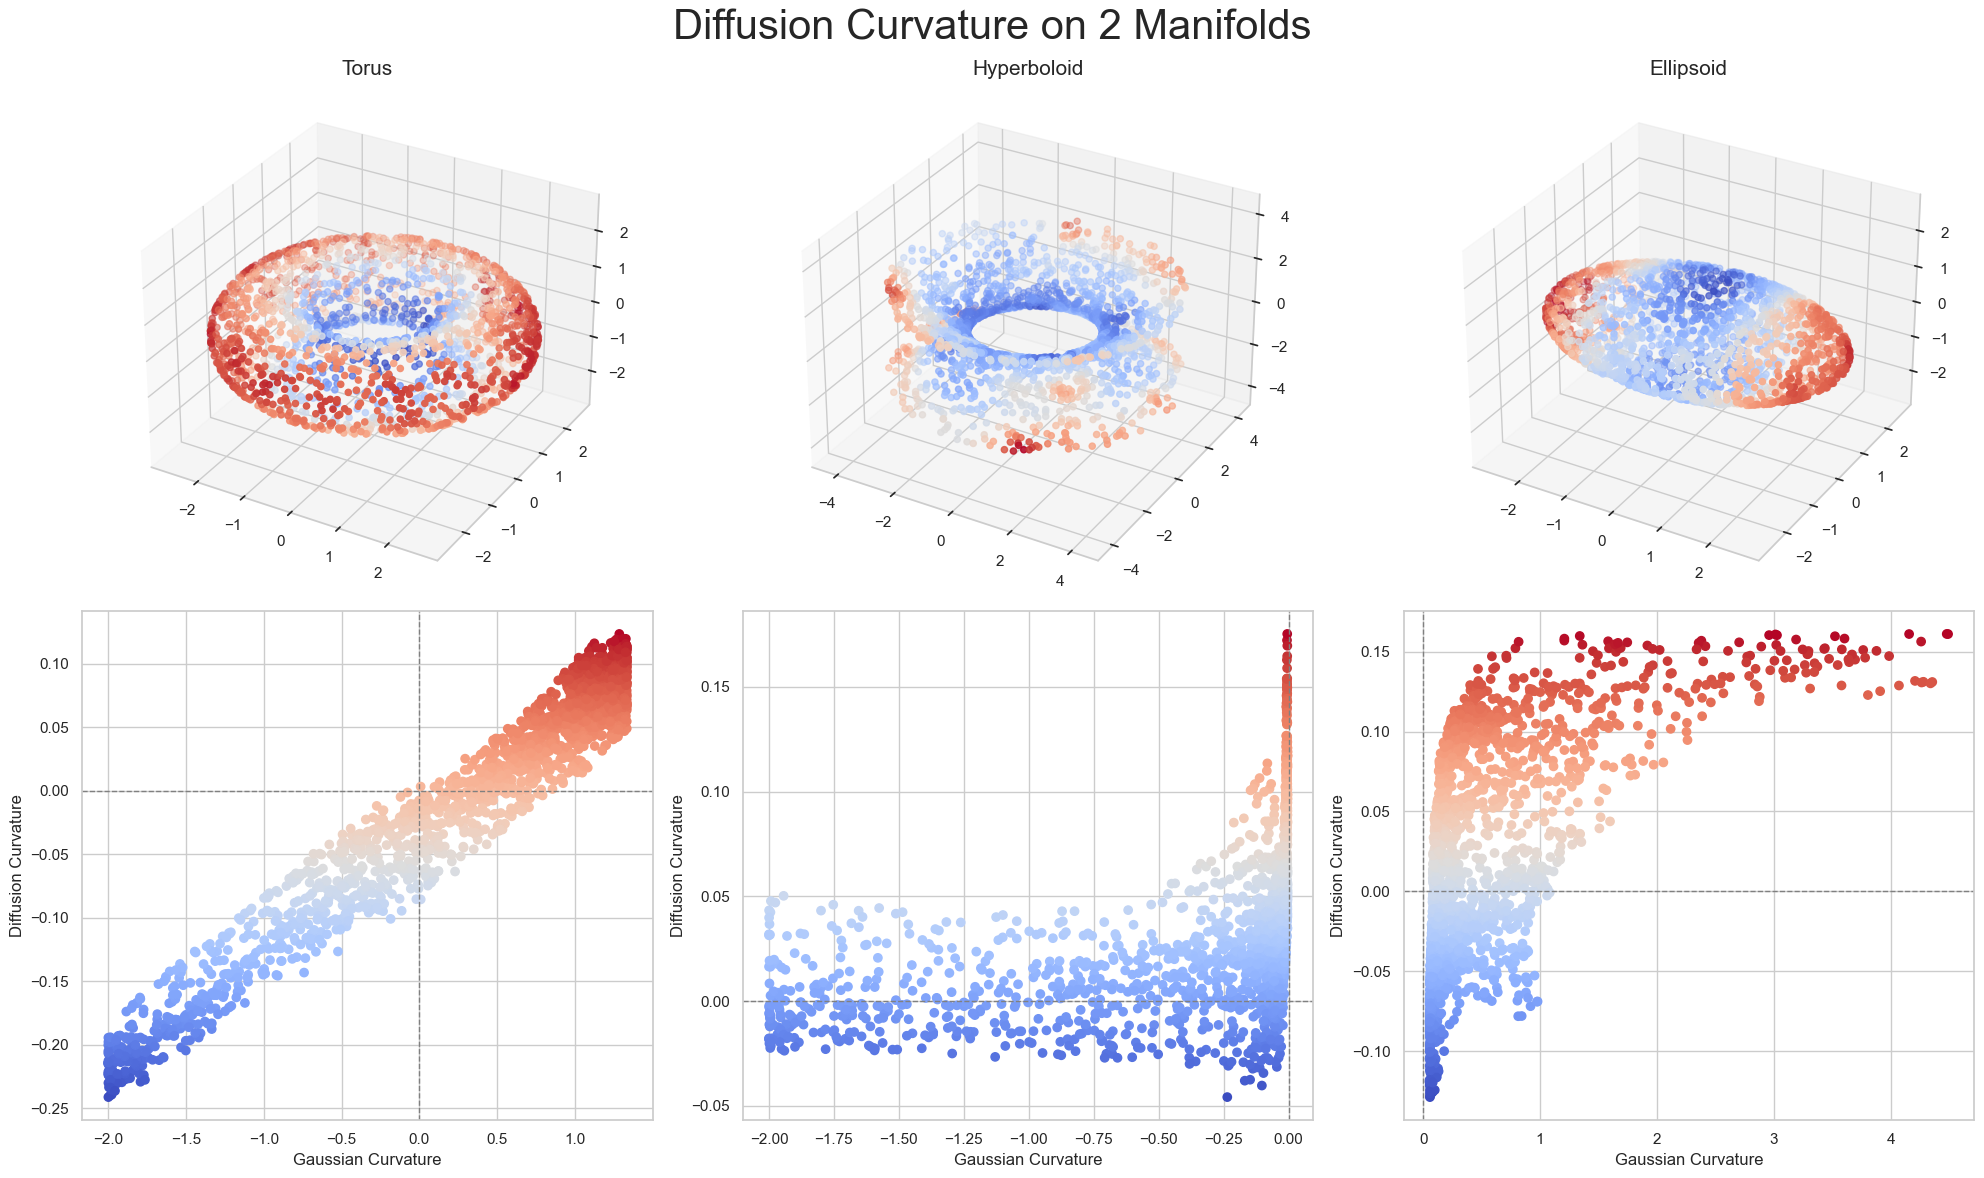

First, a sanity check. Does diffusion curvature recover the Gaussian curvature of basic 2-manifolds? <a href="#fig-2-manifolds" class="quarto-xref">Figure 2</a> shows the diffusion curvature of a Torus, Hyperboloid, and Ellipsoid, along with a scatter plot correlating diffusion curvature and Gaussian curvature. <a href="#fig-2-manifolds-visual-comparison" class="quarto-xref">Figure 3</a> places this in the context of existing methods.

``` python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Hyperboloid', 'Ellipsoid']
labels = curvatures
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

fig_shape = (len(curvatures.keys()) + 1, len(key_names))
method_colors = ['olive', 'navy', 'orange', 'purple','red']
assert len(method_colors) == len(curvatures.keys())

ordered_keys = curvatures.keys() #['Gaussian', 'Adal-PCA', 'Unsigned Diffusion Curvature', 'Hickok & Blumberg']
assert set(ordered_keys) == set(curvatures.keys())

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(fig_shape[0], fig_shape[1], figsize=(fig_shape[0]*2, fig_shape[1]*5), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    # if plt.matplotlib.__version__ >= '3.4.0':

    # plot the curvature for each method
    for j, method_name in enumerate(ordered_keys):
        axs[j, i].remove()
        axs[j, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i + j*fig_shape[1] + 1, projection='3d')
        axs[j, i].axes.set_xlim3d(left=-lim, right=lim)
        axs[j, i].axes.set_ylim3d(bottom=-lim, top=lim)
        axs[j, i].axes.set_zlim3d(bottom=-lim, top=lim)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].set_zticks([])

        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter3d = axs[j, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=scaled_labels, cmap = 'coolwarm')
        if i == 1:
            axs[j, i].set_title(f'{method_name}',fontsize=15, c = method_colors[j])

    # Scatter plot for the second row, colored by labels
    # axs[j+1, i].remove()
    # axs[j+1, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i+4)
    for k, method_name in enumerate(ordered_keys):
        # min max scaling
        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter2d = axs[j+1, i].scatter(ground_truth_labels[key], scaled_labels, c = method_colors[k], s = 1)
        axs[j+1,i].set_aspect('equal')
    # axs[1, i].set_title(f'')
    axs[j+1, i].set_xlabel('Gaussian Curvature')
    axs[j+1, i].set_ylabel('Estimated Curvature')
    
    
    # Highlight the origin lines in 2D scatter plots
    axs[j+1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[j+1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Estimated Gaussian Curvatures of 2-Manifolds", fontsize=30)
plt.tight_layout()
plt.show()
```

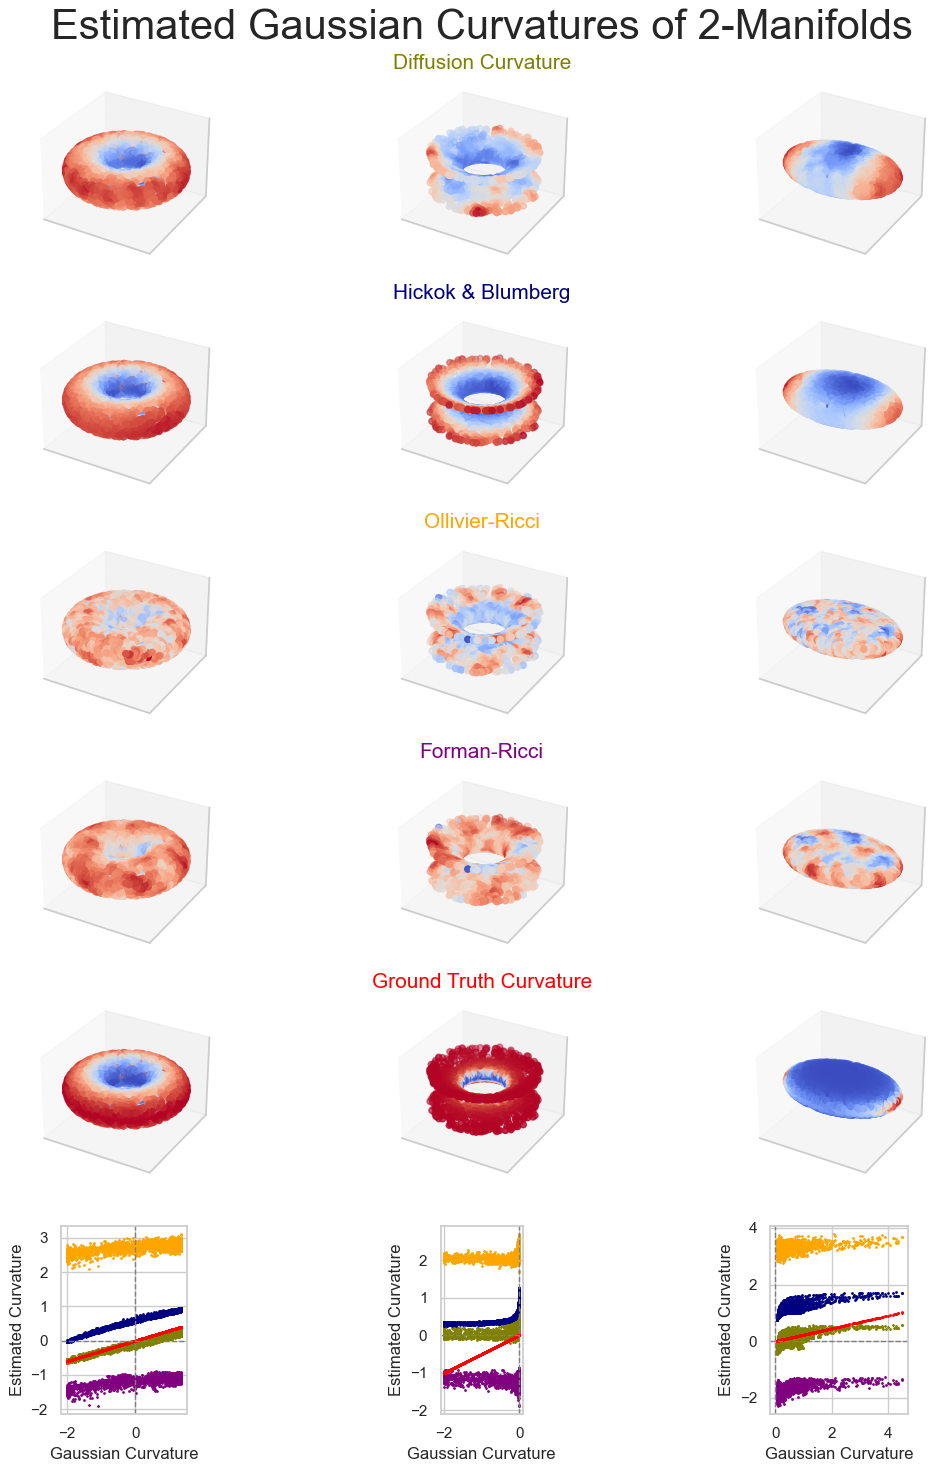

All of these methods in <a href="#fig-2-manifolds-visual-comparison" class="quarto-xref">Figure 3</a> approximately give the correct relative coloring of these 2-manifolds, except perhaps Forman-Rici. As expected, the graph-based methods, Ollivier-Ricci and Forman-Ricci, perform the worst; they weren’t designed to deal with the noise of pointcloud data. Hickok & Blumberg’s definition performs the best in terms of correspondence with the ground truth Gaussian curvature, but diffusion curvature follows it closely. Observing the bottom panel of <a href="#fig-2-manifolds-visual-comparison" class="quarto-xref">Figure 3</a>, we can see diffusion curvature corresponding closely with the red line of ground truth curvature.

In Table <a href="#fig-2-manifolds-noise-table" class="quarto-xref">Figure 4</a>, we see the results of adding Gaussian noise to each manifold. Here, the noise resilience of diffusion geometry grants diffusion curvature a huge advantage. It has the highest pearson correlation with the ground truth under all but the smallest scales of noise for the torus and ellipsoid. We suspect its correlation with the hyperboloid is lower than Hickok & Blumberg’s only because of the “edge” of this negatively-curved manifold, which creates the appearance of positive curvature.

``` python
from great_tables import GT, style, loc, exibble
from great_tables.data import sp500
import pandas as pd

df = metric_df

# Group the data by metric for proper sorting and display
df = df.sort_values(by=['Metric', 'Model']).reset_index(drop=True)

# Create the table with row groups
table = (
    GT(df, rowname_col="Model", groupname_col="Metric")
    .tab_header(title="Curvature on 2-Manifolds with Noise", subtitle="Pearson correlations and sign accuracies")
    .tab_stubhead(label="Model & Metric")
    .cols_label(
        Model="Model",
        Metric="Metric",
        **{col: col for col in df.columns if col not in ["Model", "Metric"]}
    )
    .tab_spanner(label="Torus", columns=[col for col in df.columns if "Torus" in col])
    .tab_spanner(label="Ellipsoid", columns=[col for col in df.columns if "Ellipsoid" in col])
    .tab_spanner(label="Hyperboloid", columns=[col for col in df.columns if "Hyperboloid" in col])
    .fmt_number(columns=[col for col in df.columns if col not in ["Model", "Metric"]], decimals=3)
)

# Function to apply styles to the best values
def apply_best_value_styles(df, table):
    for metric in df['Metric'].unique():
        metric_df = df[df['Metric'] == metric]
        for col in df.columns[2:]:
            # if metric == 'Pearson Correlation':
            best_value = metric_df[col].max()
            # else:  # For RMSE and other metrics where lower is better
            #     best_value = metric_df[col].min()
                
            best_indices = metric_df[metric_df[col] == best_value].index.tolist()
            for index in best_indices:
                table = table.tab_style(
                    style=style.text(weight="bold"),
                    locations=loc.body(columns=[col], rows=[index])
                )
    return table

# Apply the styles
table = apply_best_value_styles(df, table)

# Display the table (assuming in Jupyter Notebook)
display(table)
```

<div id="wbgooxrtft" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
<style>
#wbgooxrtft table {
          font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif;
          -webkit-font-smoothing: antialiased;
          -moz-osx-font-smoothing: grayscale;
        }

#wbgooxrtft thead, tbody, tfoot, tr, td, th { border-style: none; }
 tr { background-color: transparent; }
#wbgooxrtft p { margin: 0; padding: 0; }
 #wbgooxrtft .gt_table { display: table; border-collapse: collapse; line-height: normal; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3; }
 #wbgooxrtft .gt_caption { padding-top: 4px; padding-bottom: 4px; }
 #wbgooxrtft .gt_title { color: #333333; font-size: 125%; font-weight: initial; padding-top: 4px; padding-bottom: 4px; padding-left: 5px; padding-right: 5px; border-bottom-color: #FFFFFF; border-bottom-width: 0; }
 #wbgooxrtft .gt_subtitle { color: #333333; font-size: 85%; font-weight: initial; padding-top: 3px; padding-bottom: 5px; padding-left: 5px; padding-right: 5px; border-top-color: #FFFFFF; border-top-width: 0; }
 #wbgooxrtft .gt_heading { background-color: #FFFFFF; text-align: center; border-bottom-color: #FFFFFF; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; }
 #wbgooxrtft .gt_bottom_border { border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; }
 #wbgooxrtft .gt_col_headings { border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; }
 #wbgooxrtft .gt_col_heading { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 5px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; }
 #wbgooxrtft .gt_column_spanner_outer { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; padding-top: 0; padding-bottom: 0; padding-left: 4px; padding-right: 4px; }
 #wbgooxrtft .gt_column_spanner_outer:first-child { padding-left: 0; }
 #wbgooxrtft .gt_column_spanner_outer:last-child { padding-right: 0; }
 #wbgooxrtft .gt_column_spanner { border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 5px; overflow-x: hidden; display: inline-block; width: 100%; }
 #wbgooxrtft .gt_spanner_row { border-bottom-style: hidden; }
 #wbgooxrtft .gt_group_heading { padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; text-align: left; }
 #wbgooxrtft .gt_empty_group_heading { padding: 0.5px; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; vertical-align: middle; }
 #wbgooxrtft .gt_from_md> :first-child { margin-top: 0; }
 #wbgooxrtft .gt_from_md> :last-child { margin-bottom: 0; }
 #wbgooxrtft .gt_row { padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; margin: 10px; border-top-style: solid; border-top-width: 1px; border-top-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; overflow-x: hidden; }
 #wbgooxrtft .gt_stub { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-right-style: solid; border-right-width: 2px; border-right-color: #D3D3D3; padding-left: 5px; padding-right: 5px; }
 #wbgooxrtft .gt_stub_row_group { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-right-style: solid; border-right-width: 2px; border-right-color: #D3D3D3; padding-left: 5px; padding-right: 5px; vertical-align: top; }
 #wbgooxrtft .gt_row_group_first td { border-top-width: 2px; }
 #wbgooxrtft .gt_row_group_first th { border-top-width: 2px; }
 #wbgooxrtft .gt_table_body { border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; }
 #wbgooxrtft .gt_sourcenotes { color: #333333; background-color: #FFFFFF; border-bottom-style: none; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; }
 #wbgooxrtft .gt_sourcenote { font-size: 90%; padding-top: 4px; padding-bottom: 4px; padding-left: 5px; padding-right: 5px; text-align: left; }
 #wbgooxrtft .gt_left { text-align: left; }
 #wbgooxrtft .gt_center { text-align: center; }
 #wbgooxrtft .gt_right { text-align: right; font-variant-numeric: tabular-nums; }
 #wbgooxrtft .gt_font_normal { font-weight: normal; }
 #wbgooxrtft .gt_font_bold { font-weight: bold; }
 #wbgooxrtft .gt_font_italic { font-style: italic; }
 #wbgooxrtft .gt_super { font-size: 65%; }
 #wbgooxrtft .gt_footnote_marks { font-size: 75%; vertical-align: 0.4em; position: initial; }
 #wbgooxrtft .gt_asterisk { font-size: 100%; vertical-align: 0; }
 
</style>

| Curvature on 2-Manifolds with Noise      |                                              |                    |                   |                    |                   |                    |                                                    |                          |                         |                          |                         |                          |                                                  |                        |                       |                        |                       |                        |
|------------------------------------------|----------------------------------------------|--------------------|-------------------|--------------------|-------------------|--------------------|----------------------------------------------------|--------------------------|-------------------------|--------------------------|-------------------------|--------------------------|--------------------------------------------------|------------------------|-----------------------|------------------------|-----------------------|------------------------|
| Pearson correlations and sign accuracies |                                              |                    |                   |                    |                   |                    |                                                    |                          |                         |                          |                         |                          |                                                  |                        |                       |                        |                       |                        |
| Model & Metric                           | <span class="gt_column_spanner">Torus</span> |                    |                   |                    |                   |                    | <span class="gt_column_spanner">Hyperboloid</span> |                          |                         |                          |                         |                          | <span class="gt_column_spanner">Ellipsoid</span> |                        |                       |                        |                       |                        |
|                                          | Torus                                        | Torus noise = 0.05 | Torus noise = 0.1 | Torus noise = 0.15 | Torus noise = 0.2 | Torus noise = 0.25 | Hyperboloid                                        | Hyperboloid noise = 0.05 | Hyperboloid noise = 0.1 | Hyperboloid noise = 0.15 | Hyperboloid noise = 0.2 | Hyperboloid noise = 0.25 | Ellipsoid                                        | Ellipsoid noise = 0.05 | Ellipsoid noise = 0.1 | Ellipsoid noise = 0.15 | Ellipsoid noise = 0.2 | Ellipsoid noise = 0.25 |
| Pearson Correlation                      |                                              |                    |                   |                    |                   |                    |                                                    |                          |                         |                          |                         |                          |                                                  |                        |                       |                        |                       |                        |
| Diffusion Curvature                      | 0.979                                        | 0.978              | 0.978             | 0.972              | 0.959             | 0.937              | 0.471                                              | 0.501                    | 0.475                   | 0.422                    | 0.350                   | 0.297                    | 0.606                                            | 0.626                  | 0.638                 | 0.640                  | 0.634                 | 0.621                  |
| Forman-Ricci                             | 0.717                                        | 0.734              | 0.764             | 0.768              | 0.765             | 0.771              | −0.106                                             | −0.090                   | −0.080                  | −0.094                   | −0.150                  | −0.198                   | 0.482                                            | 0.511                  | 0.522                 | 0.509                  | 0.507                 | 0.502                  |
| Hickok & Blumberg                        | 0.987                                        | 0.978              | 0.950             | 0.910              | 0.861             | 0.811              | 0.651                                              | 0.650                    | 0.644                   | 0.634                    | 0.622                   | 0.614                    | 0.734                                            | 0.745                  | 0.704                 | 0.623                  | 0.544                 | 0.479                  |
| Ollivier-Ricci                           | 0.614                                        | 0.625              | 0.664             | 0.685              | 0.699             | 0.704              | 0.389                                              | 0.375                    | 0.367                   | 0.347                    | 0.328                   | 0.324                    | 0.359                                            | 0.369                  | 0.380                 | 0.394                  | 0.410                 | 0.407                  |
| Sign Accuracy                            |                                              |                    |                   |                    |                   |                    |                                                    |                          |                         |                          |                         |                          |                                                  |                        |                       |                        |                       |                        |
| Diffusion Curvature                      | 0.903                                        | 0.849              | 0.341             | 0.341              | 0.916             | 0.341              | 0.190                                              | 0.000                    | 0.266                   | 0.235                    | 0.000                   | 1.000                    | 0.509                                            | 0.529                  | 0.251                 | 0.000                  | 0.000                 | 0.000                  |
| Forman-Ricci                             | 0.341                                        | 0.341              | 0.341             | 0.341              | 0.341             | 0.341              | 1.000                                              | 1.000                    | 1.000                   | 1.000                    | 1.000                   | 1.000                    | 0.000                                            | 0.000                  | 0.000                 | 0.000                  | 0.000                 | 0.000                  |
| Hickok & Blumberg                        | 0.696                                        | 0.810              | 0.878             | 0.406              | 0.365             | 0.365              | 0.000                                              | 0.000                    | 0.215                   | 0.415                    | 0.474                   | 0.501                    | 1.000                                            | 1.000                  | 0.098                 | 0.002                  | 0.002                 | 0.002                  |
| Ollivier-Ricci                           | 0.659                                        | 0.659              | 0.659             | 0.659              | 0.659             | 0.659              | 0.000                                              | 0.000                    | 0.000                   | 0.000                    | 0.000                   | 0.000                    | 1.000                                            | 1.000                  | 1.000                 | 1.000                  | 1.000                 | 1.000                  |

</div>
        

Figure 4: Performance of methods under noise on 2-Manifolds with Noise.

## 4.2 Performance in High Dimensions under Noise

TBD!

## 4.3 Sign Differentiation

To test the ability to differentiate negative from positive curvature in high dimensions, we constructed a dataset containing saddle points, planes, and spheres in dimensions 2-6. For planes, we used uniform samples from the $d$-dimensional unit cube; for spheres, we sampled points from a Gaussian in $\mathbb{R}^d$ and normalized them to have unit length; for saddles, we constructed a quadric surface with the sign of each quadratic alternating between dimensions, and performed rejection sampling on the resulting parameterization. We sampled 2000 points from each surface, and performed this sampling 20 times per surface, creating a dataset of 60 point clouds of negative, zero, and positive curvature.

To make the comparison as fair as possible, we use our curvature-agnostic kernel to construct the graphs used for Forman-Ricci and Ollivier-Ricci curvature instead of the standard adaptive or k-nearest neighbor kernels generally used (which give worse performance). Hickok & Bloomberg’s definition operates directly on pointclouds, so we leave it as is.

As seen in <a href="#fig-sadspheres" class="quarto-xref">Figure 5</a>, only diffusion curvature differentiates the sign across all dimensions. Hickok & Blumberg’s curvature initially correctly classifies saddles as negatively curved and spheres as positive in dimension 2, however in dimensions 3-5, it classifies everything as negatively curved, with planes given a higher negative curvature than saddles. By dimension 6, it assigns the most negatively curved surface the least degree of negative curvature. For Ollivier-Ricci, the variance within samplings is extremely high (an artifact of applying a graph-based definition to noisy pointclouds), but it both describes all curvatures as positive and gives the negatively-curved dataset the highest positive curvature. Forman-Ricci does the best among these, comparatively; it at least gives saddles, spheres, and planes the correct ordering of curvature. However the magnitude of its curvatures is entirely negative; there’s no sign differentiation.

Diffusion curvature both preserves the correct relative ordering and distinguishses between the signs of saddles and spheres with 95% accuracy.

``` python
SS1._aggregate_labels()
SS1.plot_by_dimension()
```

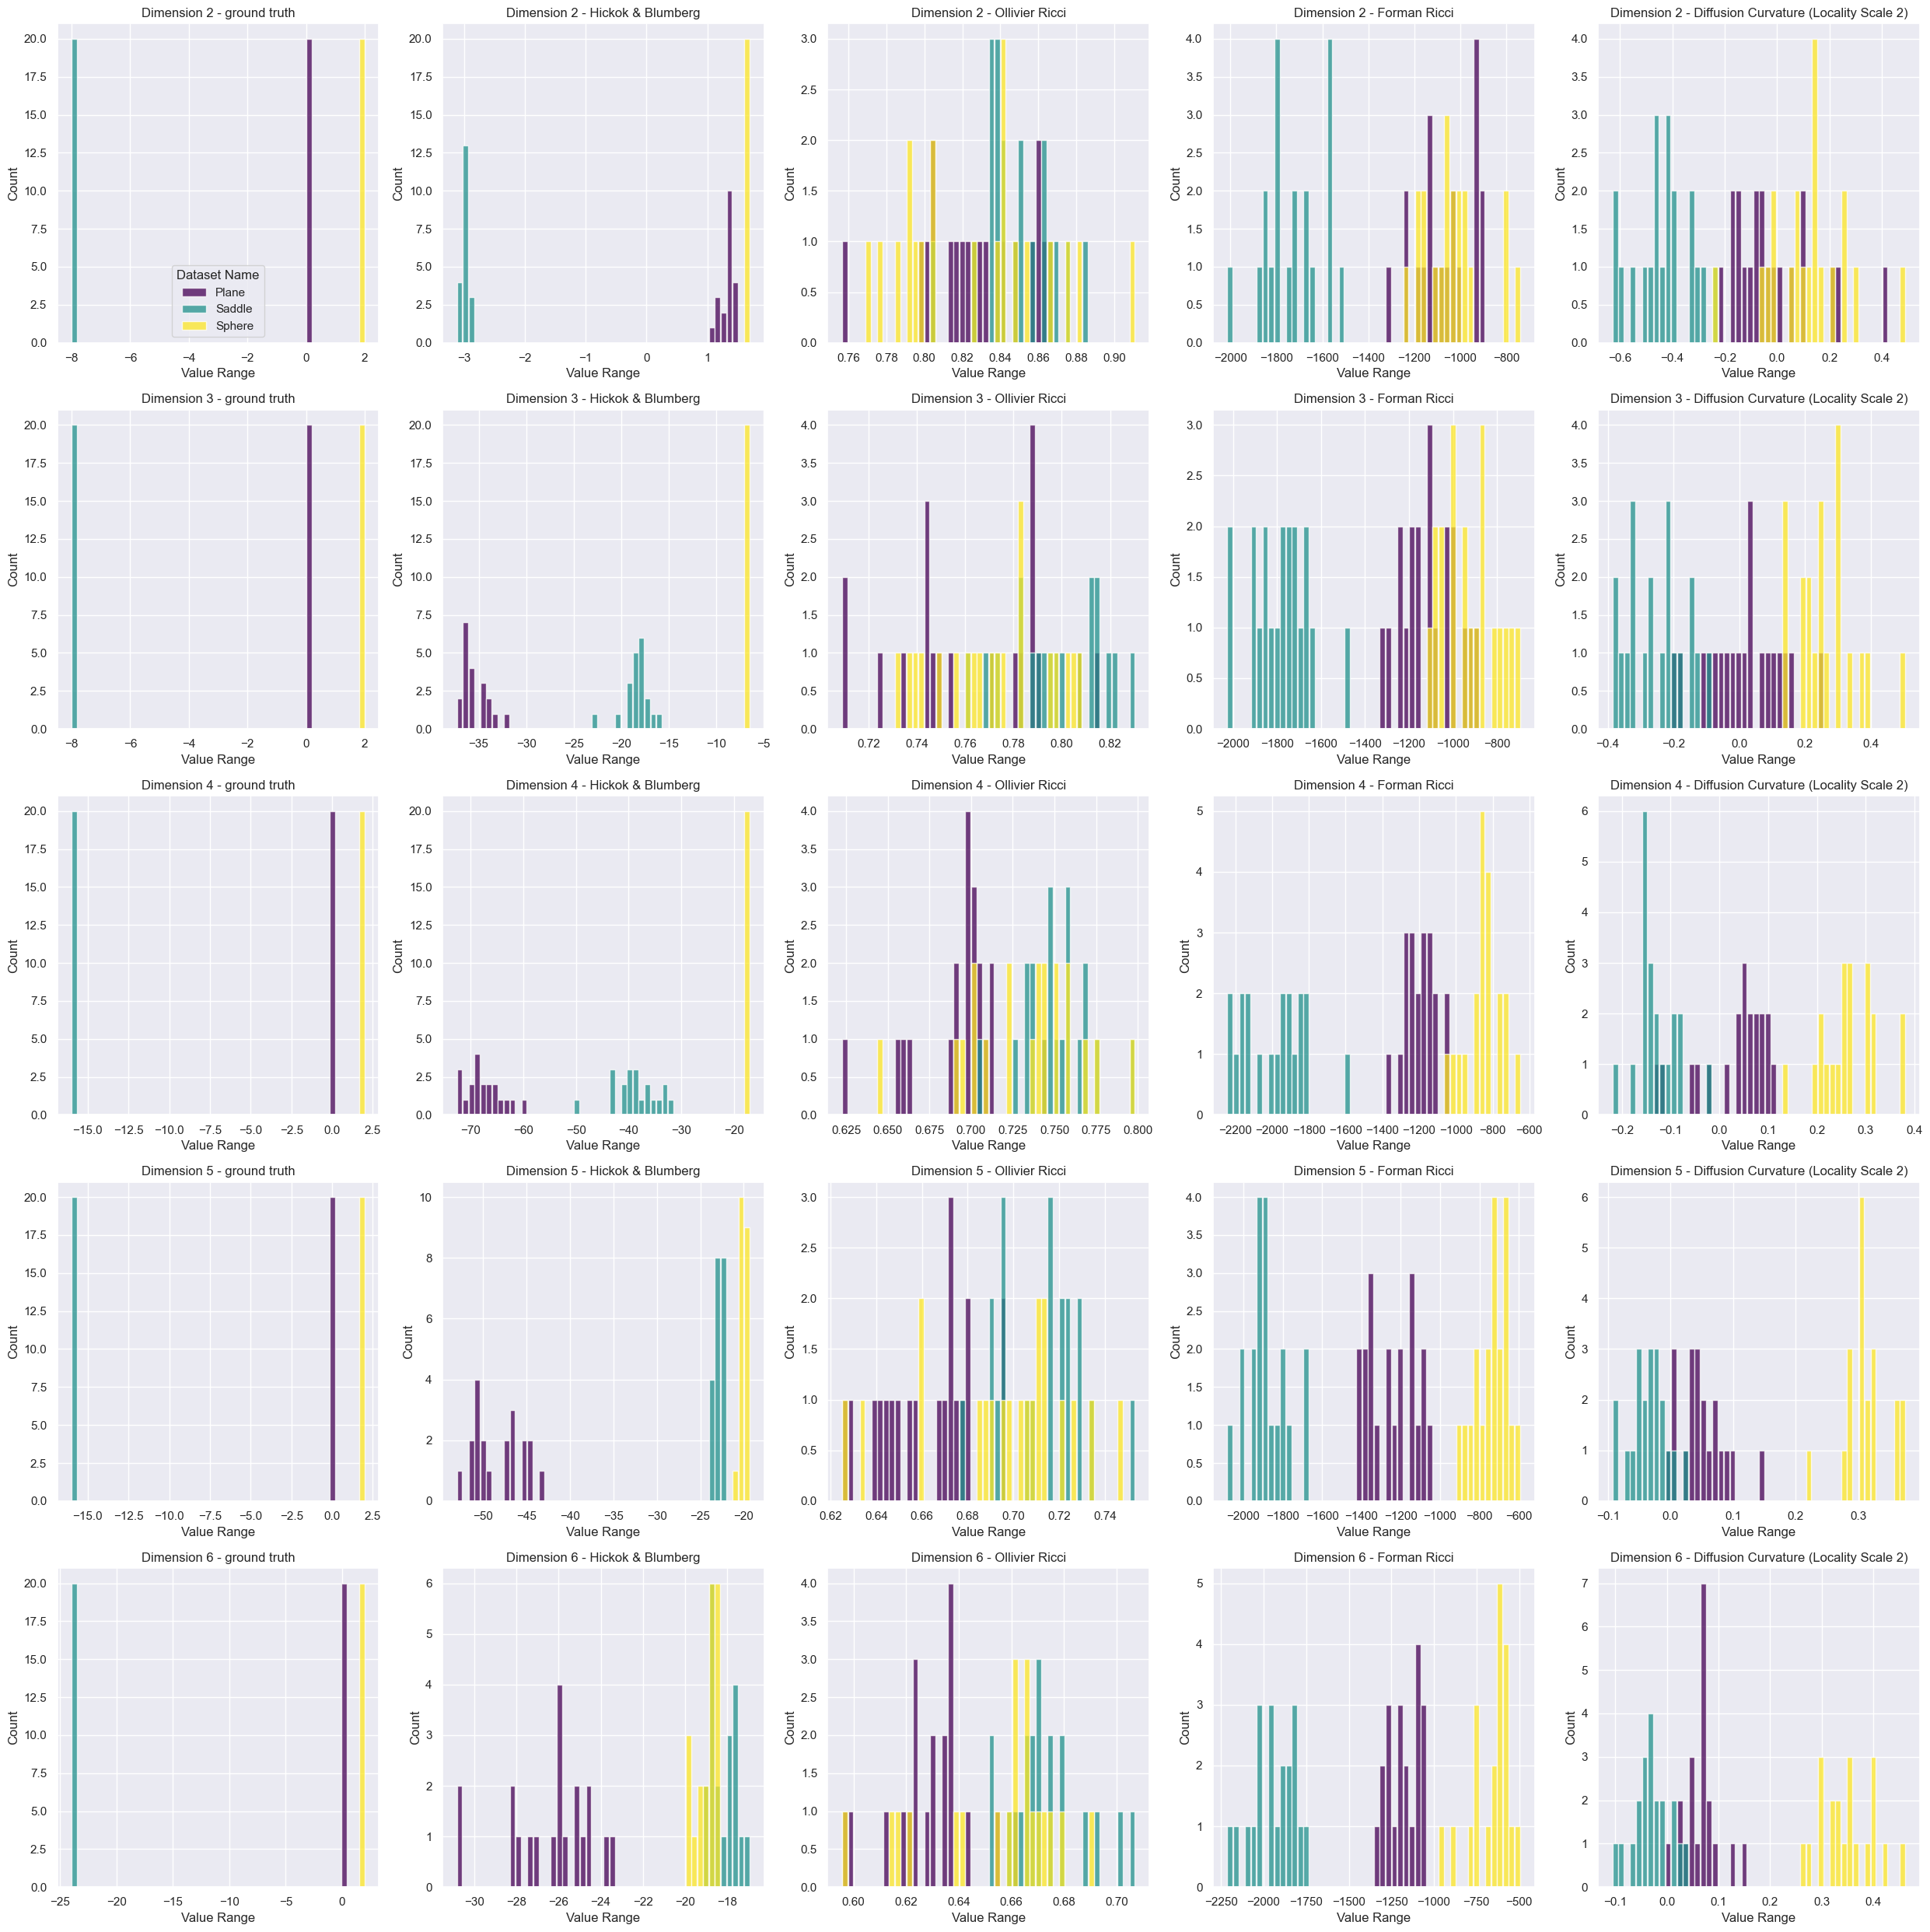

## 4.4 Resilience to Parameters

# 5. Applications

## 5.1 Single-Cell Data

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: center;"><div class="quarto-embed-nb-cell" data-notebook="/Users/adjourner/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/nbs/9-single-cell-results.ipynb" data-notebook-title="Standard libraries" data-notebook-cellId="cell-fig-single-cell-global" width="50.0%" data-layout-align="center">
<div id="cell-fig-single-cell-global" class="cell code" data-execution_count="44">
<div class="sourceCode" id="cb1"><pre class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>cmap <span class="op">=</span> plt.get_cmap(<span class="st">&#39;coolwarm&#39;</span>)</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>norm <span class="op">=</span> mcolors.TwoSlopeNorm(vmin<span class="op">=-</span>np.<span class="bu">max</span>(np.<span class="bu">abs</span>(ks_gl)), vcenter<span class="op">=</span><span class="dv">0</span>, vmax<span class="op">=</span>np.<span class="bu">max</span>(np.<span class="bu">abs</span>(ks_gl)))</span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a></span>
<span id="cb1-4"><a href="#cb1-4" aria-hidden="true" tabindex="-1"></a>plt.scatter(X_phate[:,<span class="dv">0</span>], X_phate[:,<span class="dv">1</span>],c<span class="op">=</span>ks_gl, cmap<span class="op">=</span>cmap, norm<span class="op">=</span>norm, s <span class="op">=</span> <span class="dv">1</span>)</span>
<span id="cb1-5"><a href="#cb1-5" aria-hidden="true" tabindex="-1"></a>plt.colorbar()</span>
<span id="cb1-6"><a href="#cb1-6" aria-hidden="true" tabindex="-1"></a>plt.gca().xaxis.set_ticks([])</span>
<span id="cb1-7"><a href="#cb1-7" aria-hidden="true" tabindex="-1"></a>plt.gca().yaxis.set_ticks([])</span>
<span id="cb1-8"><a href="#cb1-8" aria-hidden="true" tabindex="-1"></a></span>
<span id="cb1-9"><a href="#cb1-9" aria-hidden="true" tabindex="-1"></a>plt.show()</span></code></pre></div>
<div class="output display_data">
<p>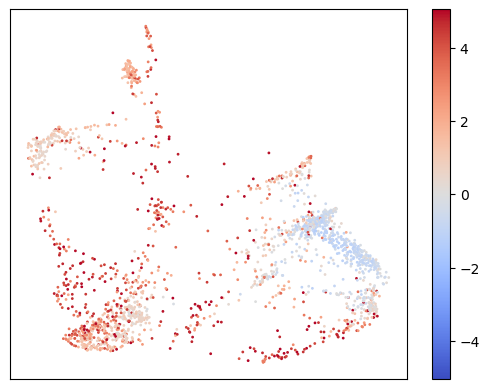</p>
</div>
</div>
</div></td>
<td style="text-align: center;"><div class="quarto-embed-nb-cell" data-notebook="/Users/adjourner/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/nbs/9-single-cell-results.ipynb" data-notebook-title="Standard libraries" data-notebook-cellId="cell-fig-single-cell-local" width="50.0%" data-layout-align="center">
<div id="cell-fig-single-cell-local" class="cell code" data-execution_count="45">
<div class="sourceCode" id="cb2"><pre class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb2-1"><a href="#cb2-1" aria-hidden="true" tabindex="-1"></a>cmap <span class="op">=</span> plt.get_cmap(<span class="st">&#39;coolwarm&#39;</span>)</span>
<span id="cb2-2"><a href="#cb2-2" aria-hidden="true" tabindex="-1"></a>norm <span class="op">=</span> mcolors.TwoSlopeNorm(vmin<span class="op">=-</span>np.<span class="bu">max</span>(np.<span class="bu">abs</span>(ks_edc)), vcenter<span class="op">=</span><span class="dv">0</span>, vmax<span class="op">=</span>np.<span class="bu">max</span>(np.<span class="bu">abs</span>(ks_edc)))</span>
<span id="cb2-3"><a href="#cb2-3" aria-hidden="true" tabindex="-1"></a></span>
<span id="cb2-4"><a href="#cb2-4" aria-hidden="true" tabindex="-1"></a><span class="im">import</span> matplotlib.pyplot <span class="im">as</span> plt</span>
<span id="cb2-5"><a href="#cb2-5" aria-hidden="true" tabindex="-1"></a>plt.scatter(X_phate[:,<span class="dv">0</span>], X_phate[:,<span class="dv">1</span>],c<span class="op">=</span>ks_edc, cmap<span class="op">=</span>cmap, norm<span class="op">=</span>norm, s <span class="op">=</span> <span class="dv">1</span>)</span>
<span id="cb2-6"><a href="#cb2-6" aria-hidden="true" tabindex="-1"></a>plt.colorbar()</span>
<span id="cb2-7"><a href="#cb2-7" aria-hidden="true" tabindex="-1"></a>plt.gca().xaxis.set_ticks([])</span>
<span id="cb2-8"><a href="#cb2-8" aria-hidden="true" tabindex="-1"></a>plt.gca().yaxis.set_ticks([])</span>
<span id="cb2-9"><a href="#cb2-9" aria-hidden="true" tabindex="-1"></a>plt.show()</span></code></pre></div>
<div class="output display_data">
<p>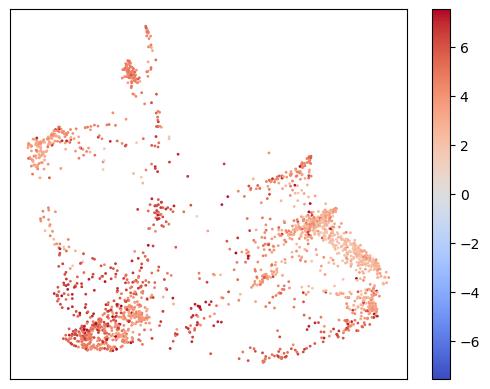</p>
</div>
</div>
</div></td>
</tr>
</tbody>
</table>

Figure 6: Diffusion Curvatures of induced pluripotent stem cells, using either global or local dimension estimation.

## 5.2 Loss Landscapes

## 5.3 Curvature as a TDA Filtration

# 6. Related Work

## 6.1 Foreman Ricci Curvature

## 6.2 Hickock & Blumberg’s Volume Comparison Curvature

## 6.3 Sritharan

# 7. Conclusion

# References

Bhaskar, Dhananjay, Kincaid MacDonald, Oluwadamilola Fasina, Dawson Thomas, Bastian Rieck, Ian Adelstein, and Smita Krishnaswamy. 2022. “Diffusion Curvature for Estimating Local Curvature in High Dimensional Data.” *Advances in Neural Information Processing Systems* 35: 21738–49. <https://proceedings.neurips.cc/paper_files/paper/2022/hash/88438dc62fc5c8777e2b5f1b4f6d37a2-Abstract-Conference.html>.

“Bishop–Gromov Inequality.” 2021. In *Wikipedia*. <https://en.wikipedia.org/w/index.php?title=Bishop%E2%80%93Gromov_inequality&oldid=1059331416>.

Coifman, Ronald R., and Stéphane Lafon. 2006. “Diffusion Maps.” *Applied and Computational Harmonic Analysis*, Special Issue: Diffusion Maps and Wavelets, 21 (1): 5–30. <https://doi.org/10.1016/j.acha.2006.04.006>.

Fasina, Oluwadamilola, Guillaume Huguet, Alexander Tong, Yanlei Zhang, Guy Wolf, Maximilian Nickel, Ian Adelstein, and Smita Krishnaswamy. 2023. “Neural FIM for Learning Fisher Information Metrics from Point Cloud Data.” June 11, 2023. <https://doi.org/10.48550/arXiv.2306.06062>.

Hickok, Abigail, and Andrew J. Blumberg. 2023. “An Intrinsic Approach to Scalar-Curvature Estimation for Point Clouds.” arXiv. <https://doi.org/10.48550/arXiv.2308.02615>.

Huguet, Guillaume, Alexander Tong, Edward De Brouwer, Yanlei Zhang, Guy Wolf, Ian Adelstein, and Smita Krishnaswamy. 2023. “A Heat Diffusion Perspective on Geodesic Preserving Dimensionality Reduction.” May 30, 2023. <https://doi.org/10.48550/arXiv.2305.19043>.

Moon, Kevin R., David van Dijk, Zheng Wang, Scott Gigante, Daniel B. Burkhardt, William S. Chen, Kristina Yim, et al. 2019. “Visualizing Structure and Transitions in High-Dimensional Biological Data.” *Nature Biotechnology* 37 (12, 12): 1482–92. <https://doi.org/10.1038/s41587-019-0336-3>.

Ollivier, Yann. 2009. “Ricci Curvature of Markov Chains on Metric Spaces.” *Journal of Functional Analysis* 256 (3): 810–64. <https://doi.org/10.1016/j.jfa.2008.11.001>.

Saloff-Coste, Laurent. 2010. “The Heat Kernel and Its Estimates.” In *Advanced Studies in Pure Mathematics*, 405–36. Kyoto University, Japan. <https://doi.org/10.2969/aspm/05710405>.

Tong, Alexander Y., Guillaume Huguet, Amine Natik, Kincaid Macdonald, Manik Kuchroo, Ronald Coifman, Guy Wolf, and Smita Krishnaswamy. 2021. “Diffusion Earth Mover’s Distance and Distribution Embeddings.” In *Proceedings of the 38th International Conference on Machine Learning*, 10336–46. PMLR. <https://proceedings.mlr.press/v139/tong21a.html>.

Tong, Alexander, Frederick Wenkel, Kincaid Macdonald, Smita Krishnaswamy, and Guy Wolf. 2021. “Data-Driven Learning of Geometric Scattering Modules for Gnns.” In *2021 IEEE 31st International Workshop on Machine Learning for Signal Processing (MLSP)*, 1–6. IEEE. <https://ieeexplore.ieee.org/abstract/document/9596169/>.

[1] Consider kernel density estimation, where one places gaussians on each data point and sums up the probability assigned to each area. The higher the curvature, the higher the reported density, since at the end of an ellipsoid the gaussians have greater overlap with each other than in its center – even though the intrinsic density of the surface is uniform.

[2] This simplex corresponds to the ‘diffusion coordinates’ used by Coifman, as well as the setting of Fasina’s diffusion-based Fisher Information metric (CITE).
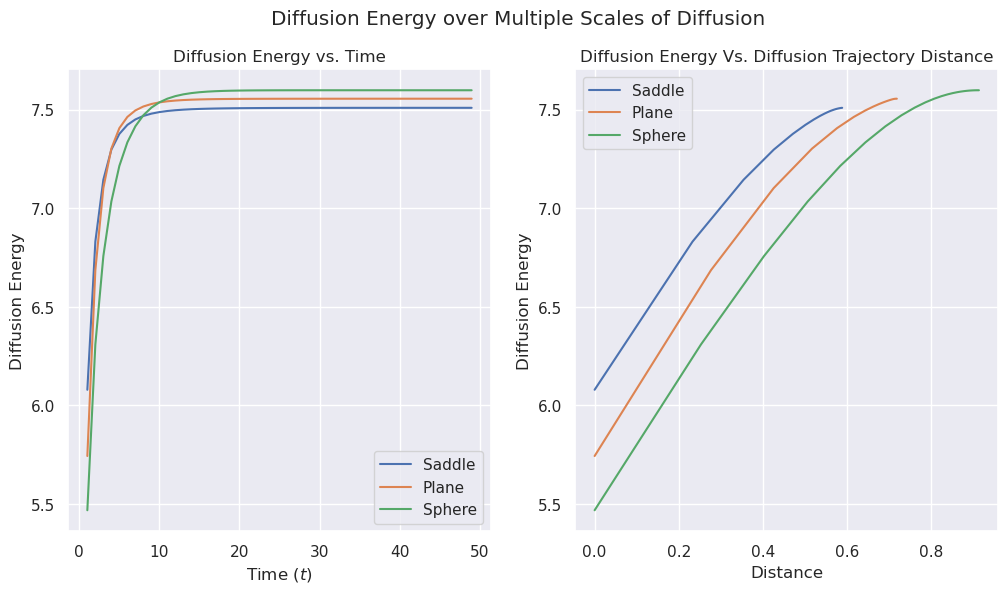